In [1]:
# ======================================================
# 1. Mount Google Drive
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ======================================================
# Imports
# ======================================================
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support, auc

In [3]:
# -------------------------
# Config
# -------------------------
IMG_H, IMG_W = 155, 220
EMBED_DIM = 128
BATCH_SIZE = 16
EPOCHS = 30
MARGIN = 1.0

# Update paths to your Drive or local dataset
path_org = "/content/drive/MyDrive/CapstoneProject/signatures/full_org"
path_forg = "/content/drive/MyDrive/CapstoneProject/signatures/full_forg"

embedding_savedir = "/content/drive/MyDrive/CapstoneProject/embedding_saved"
os.makedirs(embedding_savedir, exist_ok=True)

In [4]:
# -------------------------
# Preprocessing (shared)
# -------------------------
def preprocess_for_training_img(img_gray, target_size=(IMG_H, IMG_W)):
    # img_gray: numpy array grayscale
    img = img_gray.copy()
    img = cv2.GaussianBlur(img, (3, 3), 0)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        sig = img_bin[y:y + h, x:x + w]
    else:
        sig = img_bin

    h0, w0 = sig.shape
    # keep margin to avoid too tight crop
    scale = min(max((target_size[0] - 10) / max(h0, 1), 0.1), (target_size[1] - 10) / max(w0, 1))
    new_h, new_w = max(1, int(h0 * scale)), max(1, int(w0 * scale))
    sig = cv2.resize(sig, (new_w, new_h), interpolation=cv2.INTER_AREA)

    pad_vert = target_size[0] - new_h
    top = pad_vert // 2
    bottom = pad_vert - top
    left = (target_size[1] - new_w) // 2
    right = target_size[1] - new_w - left

    sig = np.pad(sig, ((top, bottom), (left, right)), mode='constant', constant_values=0)
    sig = sig.astype('float32') / 255.0
    sig = np.expand_dims(sig, -1)  # (H,W,1)
    return sig

def preprocess_for_training_path(path, target_size=(IMG_H, IMG_W)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"cannot read image: {path}")
    return preprocess_for_training_img(img, target_size)

In [5]:
# -------------------------
# Load files and build pairs
# -------------------------
def get_id(filename):
    parts = filename.split('_')
    try:
        return int(parts[1])
    except Exception:
        # fallback: hash
        return abs(hash(filename)) % 100000

org_files = [f for f in os.listdir(path_org) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
forg_files = [f for f in os.listdir(path_forg) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

org_dict, forg_dict = {}, {}
for f in org_files:
    pid = get_id(f)
    org_dict.setdefault(pid, []).append(f)
for f in forg_files:
    pid = get_id(f)
    forg_dict.setdefault(pid, []).append(f)

pairs, labels = [], []
# positive pairs
for pid, imgs in org_dict.items():
    if len(imgs) < 2:
        continue
    for i in range(len(imgs) - 1):
        a = preprocess_for_training_path(os.path.join(path_org, imgs[i]))
        b = preprocess_for_training_path(os.path.join(path_org, imgs[i + 1]))
        pairs.append([a, b])
        labels.append(1)

# negative pairs (org vs forg for same pid)
for pid, fimgs in forg_dict.items():
    if pid in org_dict:
        for fimg in fimgs:
            a = preprocess_for_training_path(os.path.join(path_org, random.choice(org_dict[pid])))
            b = preprocess_for_training_path(os.path.join(path_forg, fimg))
            pairs.append([a, b])
            labels.append(0)

pairs = np.array(pairs)
labels = np.array(labels)
print(f"✅ Total pairs: {len(pairs)} | Positive: {np.sum(labels)} | Negative: {len(labels) - np.sum(labels)}")

✅ Total pairs: 2585 | Positive: 1265 | Negative: 1320


In [6]:
# -------------------------
# Split data
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42)
train_img1 = np.array([x[0] for x in X_train])
train_img2 = np.array([x[1] for x in X_train])
test_img1 = np.array([x[0] for x in X_test])
test_img2 = np.array([x[1] for x in X_test])

In [14]:
# -------------------------
# Custom serializable layers (no Lambda)
# -------------------------
@tf.keras.utils.register_keras_serializable(package="Custom", name="L2Normalize")
class L2Normalize(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

    def get_config(self):
        return super().get_config()


@tf.keras.utils.register_keras_serializable(package="Custom", name="EuclideanDistance")
class EuclideanDistance(tf.keras.layers.Layer):
    def call(self, inputs):
        x, y = inputs
        return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True), 1e-7))

    def get_config(self):
        return super().get_config()

In [15]:
# -------------------------
# Build backbone (1-channel) - SAFE, no Lambda
# -------------------------
def build_base_network(input_shape=(IMG_H, IMG_W, 1)):
    inp = Input(shape=input_shape, name="input_image")

    x = Conv2D(32, (7, 7), activation='relu', padding='same', name="conv1")(inp)
    x = MaxPooling2D(name="pool1")(x)

    x = Conv2D(64, (5, 5), activation='relu', padding='same', name="conv2")(x)
    x = MaxPooling2D(name="pool2")(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name="conv3")(x)
    x = MaxPooling2D(name="pool3")(x)

    x = Flatten(name="flatten")(x)
    x = Dense(256, activation='relu', name="dense1")(x)

    # Embedding tanpa aktivasi, sebelum normalisasi
    x = Dense(EMBED_DIM, activation=None, name="embedding_raw")(x)

    # L2 normalize
    x = L2Normalize(name='l2_norm')(x)

    return Model(inp, x, name='embedding_model')
    return Model(inp, x, name='embedding_model')

embedding_model = build_base_network()
embedding_model.summary()


Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 155, 220, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 155, 220, 32)   │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 77, 110, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 77, 110, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 38, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 38, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 19, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65664)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │    16,810,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_raw (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_norm (L2Normalize)           │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,969,856 (64.73 MB)

 Trainable params: 16,969,856 (64.73 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# -------------------------
# Contrastive loss and siamese (use EuclideanDistance layer)
# -------------------------
def contrastive_loss(y_true, y_pred):
    margin = MARGIN
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(tf.maximum(margin - y_pred, 0)))

input_a = Input(shape=(IMG_H, IMG_W, 1))
input_b = Input(shape=(IMG_H, IMG_W, 1))
processed_a = embedding_model(input_a)
processed_b = embedding_model(input_b)

distance = EuclideanDistance(name='euclidean_distance')([processed_a, processed_b])
siamese_net = Model([input_a, input_b], distance)
siamese_net.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(1e-4))
siamese_net.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 128)       │ 16,969,856 │ input_layer_3[0]… │
│ (Functional)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_distance  │ (None, 1)         │          0 │ embedding_model[… │
│ (EuclideanDistance) │                   │            │ embedding_model[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,969,856 (64.73 MB)

 Trainable params: 16,969,856 (64.73 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# -------------------------
# Callbacks
# -------------------------
checkpoint_path = os.path.join(embedding_savedir, "siamese_best.weights.h5")
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [18]:
# -------------------------
# Training
# -------------------------
history = siamese_net.fit(
    [train_img1, train_img2], y_train,
    validation_data=([test_img1, test_img2], y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, es]
)


Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - loss: 0.2450 - val_loss: 0.2012
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.1441 - val_loss: 0.1789
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0831 - val_loss: 0.1600
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0405 - val_loss: 0.1463
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0242 - val_loss: 0.1407
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0156 - val_loss: 0.1344
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0108 - val_loss: 0.1308
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0070 - val_loss: 0.1283
Epoch 9/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0061 - val_loss: 0.1249
Epoch 10/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0052 - val_loss: 0.1239
Epoch 11/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0047 - val_loss: 0.1219
Epoch 12/30
130/130 ━━━━━━━━━━━━━━━━━━━

In [19]:
# -------------------------
# Save embedding model (Keras format) and weights
# -------------------------
save_path = os.path.join(embedding_savedir, "embedding_model_clean.keras")
embedding_model.save(save_path, include_optimizer=False, save_format="keras")
embedding_model.save_weights(os.path.join(embedding_savedir, "embedding_weights_clean.weights.h5"))
print("Saved embedding model to:", save_path)

Saved embedding model to: /content/drive/MyDrive/CapstoneProject/embedding_saved/embedding_model_clean.keras


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
ROC AUC: 0.9475 | EER: 0.1145 | EER_threshold: -0.5250
Precision: 0.8833 | Recall: 0.8902 | F1: 0.8867
Confusion matrix:
 [[232  30]
 [ 28 227]]


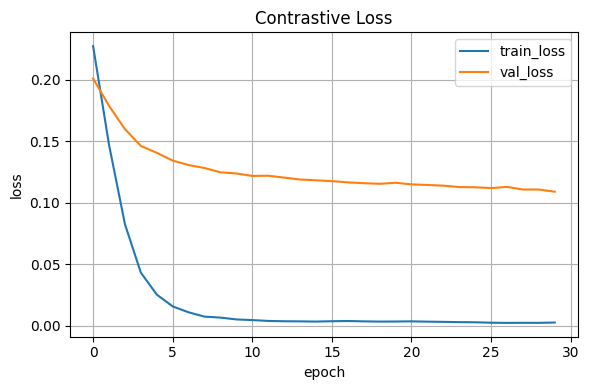

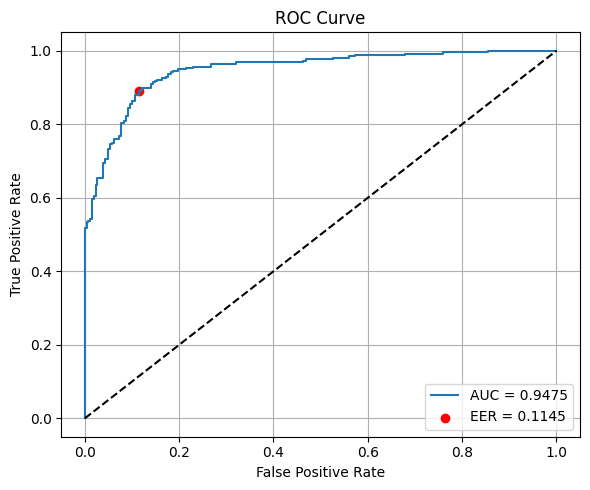

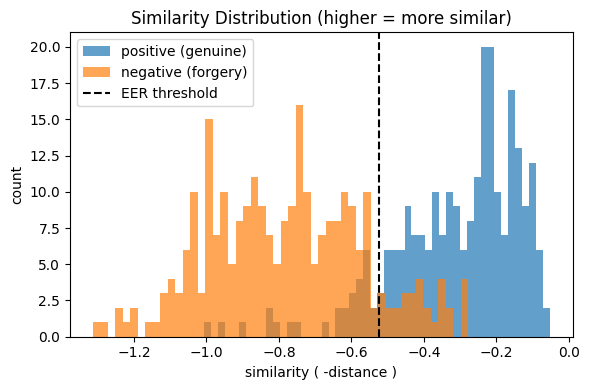

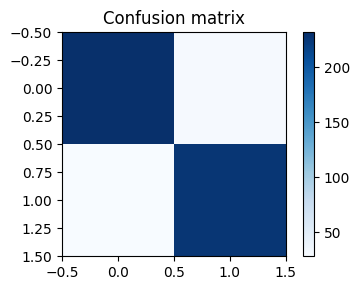

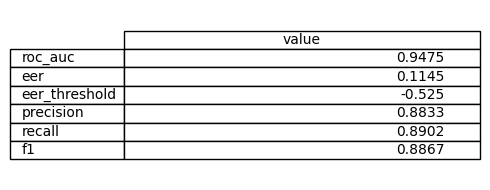

All artifacts saved to: /content/drive/MyDrive/CapstoneProject/embedding_saved


In [20]:
# -------------------------
# Evaluate & compute metrics: ROC AUC & EER + other metrics
# -------------------------
# compute distances on test
y_pred_test = siamese_net.predict([test_img1, test_img2])[:, 0]

# For ROC: convert distance -> similarity (higher better)
sim_scores = -y_pred_test
auc_score = roc_auc_score(y_test, sim_scores)
fpr, tpr, thresholds = roc_curve(y_test, sim_scores)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.absolute(fnr - fpr))
eer_threshold = thresholds[eer_idx]
eer = fpr[eer_idx]

# Convert eer_threshold (on sim_scores) to a decision on similarity
decisions = (sim_scores >= eer_threshold).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, decisions, average='binary')

# confusion matrix
cm = confusion_matrix(y_test, decisions)

# save metrics
metrics = {
    "roc_auc": float(auc_score),
    "eer": float(eer),
    "eer_threshold": float(eer_threshold),
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1)
}
np.savez(os.path.join(embedding_savedir, "metrics.npz"), **metrics)
pd.DataFrame([metrics]).to_csv(os.path.join(embedding_savedir, "metrics.csv"), index=False)

print(f"ROC AUC: {auc_score:.4f} | EER: {eer:.4f} | EER_threshold: {eer_threshold:.4f}")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
print("Confusion matrix:\n", cm)

# -------------------------
# Plotting: loss, ROC, distance histograms
# -------------------------
# 1) Training/Validation loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Contrastive Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'loss_curve.png'), dpi=150)
plt.show()

# 2) ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.scatter(fpr[eer_idx], tpr[eer_idx], c='red', label=f'EER = {eer:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'roc_curve.png'), dpi=150)
plt.show()

# 3) Histogram of similarity (pos vs neg)
sim_pos = sim_scores[y_test==1]
sim_neg = sim_scores[y_test==0]
plt.figure(figsize=(6,4))
plt.hist(sim_pos, bins=50, alpha=0.7, label='positive (genuine)')
plt.hist(sim_neg, bins=50, alpha=0.7, label='negative (forgery)')
plt.axvline(eer_threshold, color='k', linestyle='--', label='EER threshold')
plt.title('Similarity Distribution (higher = more similar)')
plt.xlabel('similarity ( -distance )')
plt.ylabel('count')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'similarity_hist.png'), dpi=150)
plt.show()

# 4) Save confusion matrix as CSV and as small figure
pd.DataFrame(cm, index=['neg','pos'], columns=['pred_neg','pred_pos']).to_csv(os.path.join(embedding_savedir, 'confusion_matrix.csv'))
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'confusion_matrix.png'), dpi=150)
plt.show()

# 5) Save a readable metrics table image (basic)
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ['value']
metrics_df.to_csv(os.path.join(embedding_savedir, 'metrics_table.csv'))
plt.figure(figsize=(5,2))
plt.axis('off')
tbl = plt.table(cellText=np.round(metrics_df.values,4), rowLabels=metrics_df.index, colLabels=metrics_df.columns, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
plt.tight_layout()
plt.savefig(os.path.join(embedding_savedir, 'metrics_table.png'), dpi=150)
plt.show()

print("All artifacts saved to:", embedding_savedir)